# Introduction

In this notebook I try to design a solution based monitor function that resembles the Bakhvalov monitor function. To do so, I try to pick scalars $a, b,c$ such that $ M = c(1 + \alpha | \nabla_x u|^a)^b $ resembles the Bakhvalov monitor function.

# Results

Our inability to choose an $a,b,c$ that work is another motivation for us to use a monitor function based on $u''$

# Imports

In [1]:
# install firedrake

# hide output
%%capture

try:
    import firedrake
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    import firedrake

In [2]:
# Code in this cell makes plots appear an appropriate size and resolution in the browser window

%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (11, 6)

In [3]:
# import firedrake tools

from firedrake import *
import numpy as np
import matplotlib.pyplot as plt # firedrake makes use of matplotlib tools
from firedrake.pyplot import tripcolor, tricontour, triplot #firedrake plotting
from IPython.display import display
from mpl_toolkits import mplot3d


# connect to drive for plot saving
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


# Chosen Known solution

In [4]:
def known_solution(x, epsilon):

  eps = Constant(epsilon)

  u_known = cos( (pi*x) / 2 ) - ( exp(-x/eps) - exp(-1/eps) ) / (1 - exp(-1/eps))

  return u_known

# Working on all the pieces of the MP - Iteration

## Set the Interval $x$ Mesh

In [5]:
N = 24
x_mesh = UnitIntervalMesh(N)
x_coord = SpatialCoordinate(x_mesh)
V = FunctionSpace(x_mesh, "CG", 2)
W = FunctionSpace(x_mesh,"CG", 1)


[-0.          0.00174023  0.00364643  0.00575364  0.0081093   0.01077993
  0.01386294  0.01750937  0.02197225  0.02772589  0.03583519  0.04969813
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.        ]
[-0.          0.00174023  0.00364643  0.00575364  0.0081093   0.01077993
  0.01386294  0.01750937  0.02197225  0.02772589  0.03583519  0.04969813
  0.09621714  0.17153238  0.24684761  0.32216285  0.39747809  0.47279333
  0.54810857  0.62342381  0.69873905  0.77405428  0.84936952  0.92468476
  0.        ]


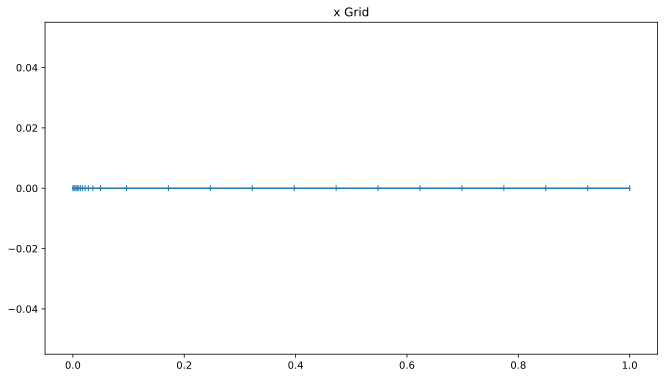

In [6]:
# Create a B mesh

tau = 0
tauold = -11

sigma = 2
epsilon = 0.01
beta = 1
q = 0.5
layers = 1
N = 24

meps = sigma*epsilon/beta


while tau >= 0 and np.abs(tau - tauold ) > 1*10**(-10):
  tauold = tau
  #print(tau)

  chitau = meps*np.log(q/(q-tau))

  if (layers == 2):
    tau = q - meps*(1 - 2*tau)/(1-2*chitau)
  else:
    tau = q - meps*(1-tau)/(1-chitau)
chitau = meps*np.log(q/(q-tau))



if chitau < 0.0:
  xB = np.linspace(0,1,N+1)

else:
  xB = np.zeros(N+1)
  if layers == 2:
    i = np.arange(0,N/2)
    k = np.searchsorted(i/N, tau)
    for p in range(0,k):
      xB[p] = -meps*np.log(1 - (i[p])/N/q)
    print(xB)
    for p in range(k,int(N/2)):
      xB[p] = chitau + (1-2*chitau)/(1 - 2*tau) * ((i[p])/N - tau)
    xB[int(N/2)] = 0.5
    for p in range(int(N/2) + 1, N+1):
      xB[p] = 1 - xB[N-p]
    print(xB)
  else:
    i = np.arange(0,N)
    k = np.searchsorted(i/N, tau)
    for p in range(0,k):
      xB[p] = -meps*np.log(1 - (i[p])/N/q)
    print(xB)
    for p in range(k,N):
      xB[p] = chitau + (1-chitau)/(1-tau) * ((i[p])/N-tau)
    print(xB)
    xB[N] = 1

yvals = np.linspace(0,1,len(xB))



# set the B mesh

x_mesh.coordinates.dat.data[:] = xB[:]
x_plot = x_mesh.coordinates.dat.data
plt.plot(x_plot, [0 for i in range(len(x_plot))], marker = "|")
plt.title("x Grid")
plt.show()

## Physical Solve

In [7]:
epsilon = 0.01

u = TrialFunction(V)
v = TestFunction(V)
eps = Constant(epsilon)
x = Function(W).interpolate(x_coord[0])


# The rhs

u_known = cos(pi*x / 2) - ( exp(-x/eps) - exp(-1/eps) ) / (1 - exp(-1/eps) )
u_prpr = (-pi**2)/4 * cos(pi*x / 2) - ( exp(-x/eps) ) / ( eps**2 * ( 1 - exp(-1/eps)) )
f = -eps**2 * u_prpr +  u_known


# The terms of the weak form

u_deriv = grad(u)
v_deriv = grad(v)

term1 = eps**2 * inner(u_deriv, v_deriv)
term2 = inner(u, v)

a = (term1 + term2) * dx

L = inner(f, v) * dx

# BC's

bcs = DirichletBC(V, known_solution(x, epsilon), "on_boundary")

# Solve the problem

u_sol = Function(V)
solve( a == L, u_sol, bcs)

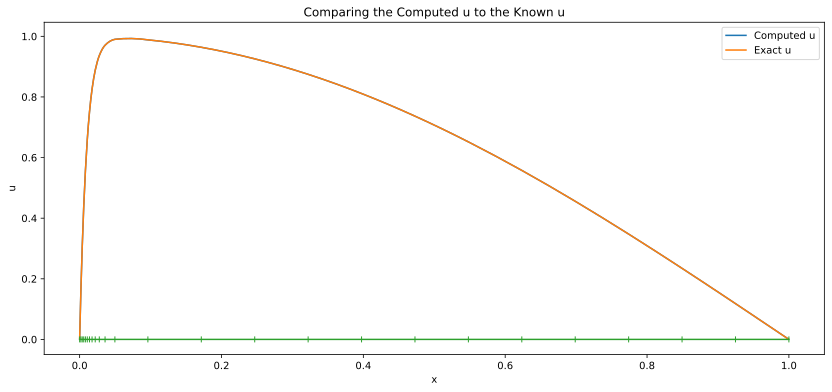

In [8]:
fig, axes = plt.subplots(figsize = (14,  6))

firedrake.pyplot.mpl.plot( u_sol, label = "Computed u", axes = axes)
firedrake.pyplot.mpl.plot(Function(V).interpolate(known_solution(x, epsilon)), label = "Exact u", axes = axes)
plt.plot(x.dat.data, [0 for i in range(len(x.dat.data))], marker = "|", axes = axes)
axes.set_title("Comparing the Computed u to the Known u")
axes.set_xlabel("x")
axes.set_ylabel("u")
axes.legend()
plt.show()

## Mesh Density Function

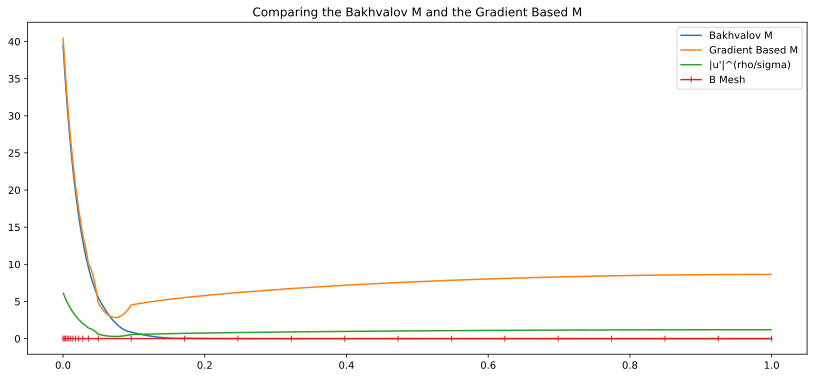

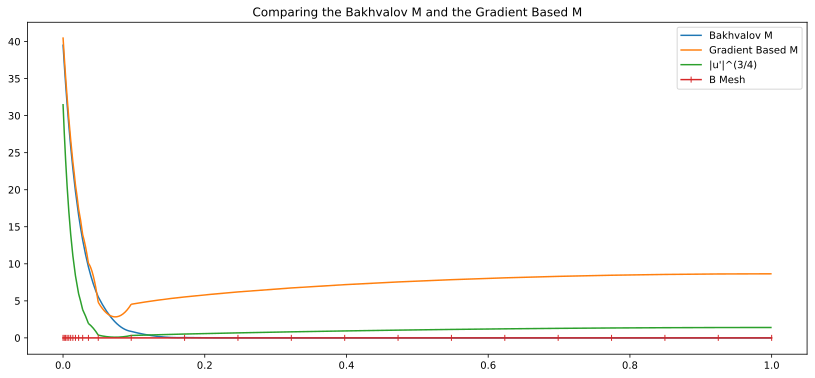

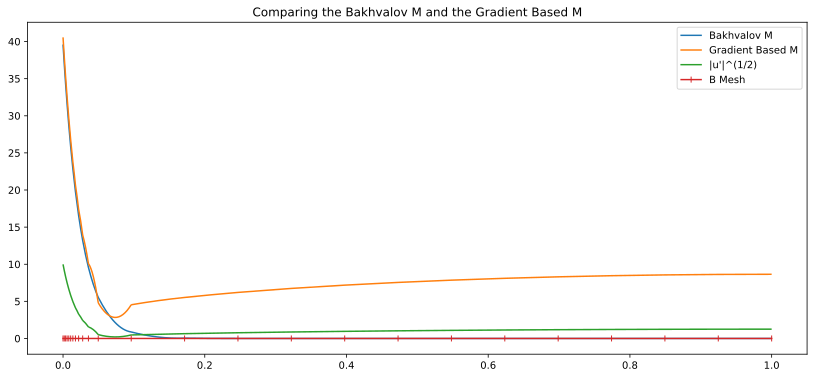

In [9]:
# Bakhvalov based M

K0 = 0.4 # weight of points in layers
K1 = 0.4
rho = 0.99  # c >= rho^2
sigma = 2.5  # sigma > order of FEM + 1
Mt = K0 * rho * (1/eps) * ( exp( (-rho*x) / (sigma*eps) ) )
MB = 1 + Mt


# fake u'
# upr = (-pi/2) * sin(pi*x/2) + (exp(-x/eps))/(eps*(1-exp(-1/eps)))
# upr_wo_sin =  (exp(-x/eps))/(eps*(1-exp(-1/eps)))



# Gradient Based M

grad_x_sol = u_sol.dx(0)
# alpha = 0.6325
smile = rho/sigma
alpha = K0 * rho *  eps**(smile-1) * ( 1 - exp(-1/eps))**smile
a = smile
b = 1
c = 1
MG = c * (1 + alpha * abs( grad_x_sol )**a)**b




# plot both

fig, axes = plt.subplots(figsize = (14,  6))
firedrake.pyplot.mpl.plot(Function(V).interpolate(MB-1), label = "Bakhvalov M ", axes = axes)
firedrake.pyplot.mpl.plot(Function(V).interpolate(MG), label = "Gradient Based M", axes = axes)
firedrake.pyplot.mpl.plot( Function(V).interpolate(abs(grad_x_sol)**(smile)), label = "|u'|^(rho/sigma)", axes = axes)
plt.plot(x.dat.data, [0 for i in range(len(x.dat.data))], marker = "|", axes = axes, label = "B Mesh")
plt.legend()
plt.title('Comparing the Bakhvalov M and the Gradient Based M')
# pdf_path = '/content/drive/My Drive/Summer_2024_Work/Compare_BM_and_GradM.pdf'
# plt.savefig(pdf_path)
plt.show()

fig, axes = plt.subplots(figsize = (14,  6))
firedrake.pyplot.mpl.plot(Function(V).interpolate(MB-1), label = "Bakhvalov M", axes = axes)
firedrake.pyplot.mpl.plot(Function(V).interpolate(MG), label = "Gradient Based M", axes = axes)
firedrake.pyplot.mpl.plot( Function(V).interpolate(abs(grad_x_sol)**(3/4)), label = "|u'|^(3/4)", axes = axes)
plt.plot(x.dat.data, [0 for i in range(len(x.dat.data))], marker = "|", axes = axes, label = "B Mesh")
plt.legend()
plt.title('Comparing the Bakhvalov M and the Gradient Based M')
# pdf_path = '/content/drive/My Drive/Summer_2024_Work/Compare_BM_and_GradM.pdf'
# plt.savefig(pdf_path)
plt.show()

fig, axes = plt.subplots(figsize = (14,  6))
firedrake.pyplot.mpl.plot(Function(V).interpolate(MB-1), label = "Bakhvalov M", axes = axes)
firedrake.pyplot.mpl.plot(Function(V).interpolate(MG), label = "Gradient Based M", axes = axes)
firedrake.pyplot.mpl.plot( Function(V).interpolate(abs(grad_x_sol)**(1/2)), label = "|u'|^(1/2)", axes = axes)
plt.plot(x.dat.data, [0 for i in range(len(x.dat.data))], marker = "|", axes = axes, label = "B Mesh")
plt.legend()
plt.title('Comparing the Bakhvalov M and the Gradient Based M')
# pdf_path = '/content/drive/My Drive/Summer_2024_Work/Compare_BM_and_GradM.pdf'
# plt.savefig(pdf_path)
plt.show()